## We apply a home-baked `gaussian_filter`

In [1]:
%matplotlib inline

import sys
import datacube
from datacube.utils.cog import write_cog

#from scipy.ndimage import gaussian_filter

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

from osgeo import gdal
from gdal import gdalconst

sys.path.append('../Scripts')
from deafrica_datahandling import wofs_fuser

In [2]:
dc = datacube.Datacube(app='gaussian_DEM')

In [3]:
# Define the central point of the area of interest
lat, lon = -19.85, 34.70

# buffer will define the upper and lower boundary from the central point
buffer = 0.1   

# Combine central lat, lon with buffer to get area of interest
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

In [4]:
# Create a query
dem30_query = {
    'x': (lon_range),
    'y': (lat_range),
    'output_crs': 'EPSG:2736',    # utm36s
    'resolution': (-30, 30)
}

# Create a query for a 50 meter dem ~ we do this because we want the extent, shape and geotransform
dem50_query = {
    'x': (lon_range),
    'y': (lat_range),
    'output_crs': 'EPSG:2736',    # utm36s
    'resolution': (-60, 60)
}

#load elevation
elevation_array30 = dc.load(product ='srtm', **dem30_query)
elevation_array60 = dc.load(product ='srtm', **dem50_query)

#elevation_array

In [14]:
#convert to an dataArray (rather than Dataset) and select single time-slice
dem30 = elevation_array30[['elevation']].isel(time=0).to_array()
dem60 = elevation_array60[['elevation']].isel(time=0).to_array()

### Home-baked Gaussian Blur

In [7]:
from scipy.signal import fftconvolve

def gaussian_blur1d(in_array, size):
        #check validity
        try:
            if 0 in in_array.shape:
                raise Exception("Null array can't be processed!")
        except TypeError:
            raise Exception("Null array can't be processed!")
            
        # expand in_array to fit edge of kernel
        padded_array = np.pad(in_array, size, 'symmetric').astype(float)
        
        # build kernel
        x, y = np.mgrid[-size:size + 1, -size:size + 1]
        g = np.exp(-(x**2 / float(size) + y**2 / float(size)))
        g = (g / g.sum()).astype(float)
        
        # do the Gaussian blur
        out_array = fftconvolve(padded_array, g, mode='valid')
        return out_array.astype(in_array.dtype)

In [39]:
Gblur05 = gaussian_blur1d(dem30.squeeze(), size=5)
Gblur10 = gaussian_blur1d(dem30.squeeze(), size=10)
Gblur20 = gaussian_blur1d(dem30.squeeze(), size=20)
Gblur30 = gaussian_blur1d(dem30.squeeze(), size=30)
Gblur40 = gaussian_blur1d(dem30.squeeze(), size=40)

In [34]:
#Gblur

array([[6, 6, 6, ..., 7, 7, 6],
       [6, 6, 6, ..., 7, 7, 6],
       [6, 6, 6, ..., 7, 7, 6],
       ...,
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0]], dtype=int16)

In [40]:
#create a DataArray object
da5 = xr.DataArray(data = Gblur05,
                  coords = {'y': dem30.y, 
                            'x': dem30.x,
                            'spatial_ref': 2736
                            #'variable': Gblur.squeeze()
                           },
                  #variable = {'elevation': Gblur},
                  attrs = {'crs': 'EPSG:2736'},
                  dims = ["y", "x"])


da10 = xr.DataArray(data = Gblur10,
                  coords = {'y': dem30.y, 
                            'x': dem30.x,
                            'spatial_ref': 2736
                            #'variable': Gblur.squeeze()
                           },
                  #variable = {'elevation': Gblur},
                  attrs = {'crs': 'EPSG:2736'},
                  dims = ["y", "x"])

da20 = xr.DataArray(data = Gblur20,
                  coords = {'y': dem30.y, 
                            'x': dem30.x,
                            'spatial_ref': 2736
                            #'variable': Gblur.squeeze()
                           },
                  #variable = {'elevation': Gblur},
                  attrs = {'crs': 'EPSG:2736'},
                  dims = ["y", "x"])

da30 = xr.DataArray(data = Gblur30,
                  coords = {'y': dem30.y, 
                            'x': dem30.x,
                            'spatial_ref': 2736
                            #'variable': Gblur.squeeze()
                           },
                  #variable = {'elevation': Gblur},
                  attrs = {'crs': 'EPSG:2736'},
                  dims = ["y", "x"])

da40 = xr.DataArray(data = Gblur40,
                  coords = {'y': dem30.y, 
                            'x': dem30.x,
                            'spatial_ref': 2736
                            #'variable': Gblur.squeeze()
                           },
                  #variable = {'elevation': Gblur},
                  attrs = {'crs': 'EPSG:2736'},
                  dims = ["y", "x"])

#da

### `spatial_ref` might be possible through

In [ ]:
import rioxarray
from pyproj import CRS

cc = CRS.from_cf(dem30.spatial_ref.attrs) 
da.rio.write_crs(cc.to_string(), inplace=True)

In [63]:
#dataset.GetProjection()

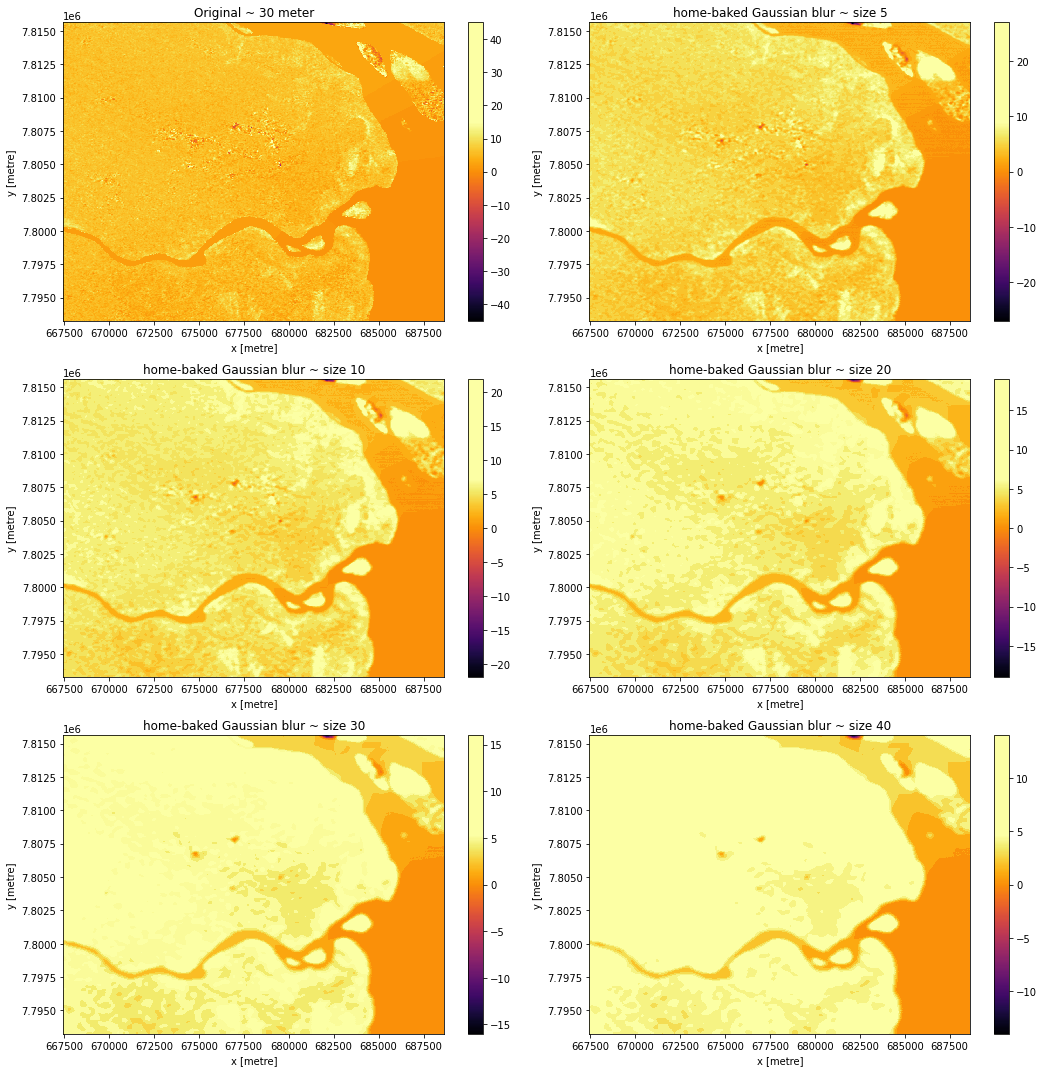

In [67]:
# Plot the elevation data
# Create a custom colourmap for the DEM
colors_terrain = plt.cm.inferno(np.linspace(0.0, 1.5, 25))
cmap_terrain = mpl.colors.LinearSegmentedColormap.from_list('inferno', colors_terrain)

fig = plt.figure(figsize=(15, 15))

#fig, axs = plt.subplots(2, 2, figsize=(16, 4), sharey=True, sharex=True)
ax1 = fig.add_subplot(321)
dem30.plot(ax=ax1, cmap=cmap_terrain)
ax1.set_title('Original ~ 30 meter')

ax2 = fig.add_subplot(322)
da5.plot(ax=ax2, cmap=cmap_terrain)
ax2.set_title('home-baked Gaussian blur ~ size 5')

ax3= fig.add_subplot(323)
da10.plot(ax=ax3, cmap=cmap_terrain)
ax3.set_title('home-baked Gaussian blur ~ size 10')

ax4= fig.add_subplot(324)
da20.plot(ax=ax4, cmap=cmap_terrain)
ax4.set_title('home-baked Gaussian blur ~ size 20')

ax5= fig.add_subplot(325)
da30.plot(ax=ax5, cmap=cmap_terrain)
ax5.set_title('home-baked Gaussian blur ~ size 30')

ax6= fig.add_subplot(326)
da40.plot(ax=ax6, cmap=cmap_terrain)
ax6.set_title('home-baked Gaussian blur ~ size 40')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

plt.tight_layout() 
plt.show()

In [68]:
print(dem30.squeeze().shape)
print(da5.shape)
print(da10.shape)
print(da20.shape)
print(da30.shape)
print(da40.shape)
print('')
#print(dem.crs)
print(dem30.size)
print(da5.size)
print(da10.size)
print(da20.size)
print(da30.size)
print(da40.size)

(746, 706)
(746, 706)
(746, 706)
(746, 706)
(746, 706)
(746, 706)

526676
526676
526676
526676
526676
526676


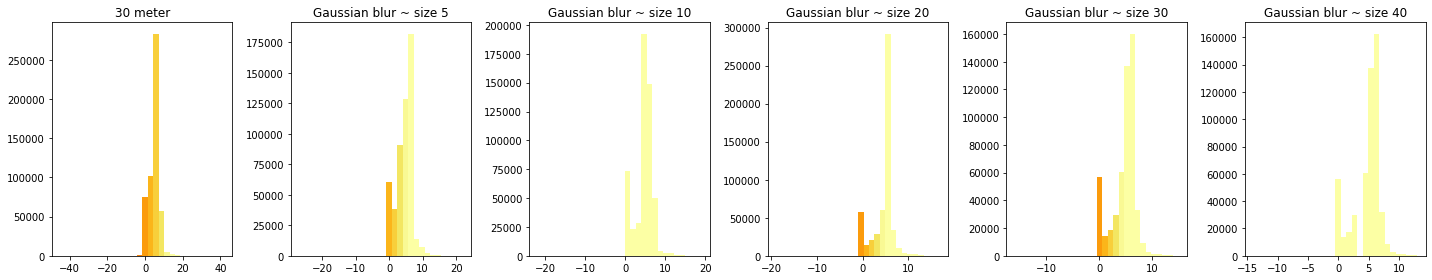

In [69]:
### Plot instance
f, ax = plt.subplots(1, 6, figsize=(20, 4))

# histogram.
n, bins, patches = dem30.squeeze().plot.hist(ax=ax[0],
                                           color="purple",
                                           bins=30)                 # feel free to change these 
ax[0].set_title('30 meter')
bin_centers = 0.8 * (bins[:-1] + bins[1:])
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cmap_terrain(c))
    
# histogram.
n, bins2, patches = da5.plot.hist(ax=ax[1],
                                color="purple",
                                bins=30)                              # feel free to change these 
ax[1].set_title('Gaussian blur ~ size 5')
bin_centers2 = 0.8 * (bins2[:-1] + bins2[1:])
# scale values to interval [0,1]
col2 = bin_centers2 - min(bin_centers2)
col2 /= max(col2)
for c, p2 in zip(col2, patches):
    plt.setp(p2, 'facecolor', cmap_terrain(c))

# histogram.
n, bins3, patches = da10.plot.hist(ax=ax[2],
                                color="purple",
                                bins=30)                              # feel free to change these 
ax[2].set_title('Gaussian blur ~ size 10')
bin_centers3 = 0.8 * (bins3[:-1] + bins3[1:])
# scale values to interval [0,1]
col3 = bin_centers3 - min(bin_centers3)
col3 /= max(col2)
for c, p3 in zip(col3, patches):
    plt.setp(p3, 'facecolor', cmap_terrain(c))
    
# histogram.
n, bins4, patches = da20.plot.hist(ax=ax[3],
                                color="purple",
                                bins=30)                              # feel free to change these 
ax[3].set_title('Gaussian blur ~ size 20')
bin_centers4 = 0.8 * (bins4[:-1] + bins4[1:])
# scale values to interval [0,1]
col4 = bin_centers4 - min(bin_centers4)
col4 /= max(col4)
for c, p4 in zip(col4, patches):
    plt.setp(p4, 'facecolor', cmap_terrain(c))
    
# histogram.
n, bins5, patches = da30.plot.hist(ax=ax[4],
                                color="purple",
                                bins=30)                              # feel free to change these 
ax[4].set_title('Gaussian blur ~ size 30')
bin_centers5 = 0.8 * (bins5[:-1] + bins5[1:])
# scale values to interval [0,1]
col5 = bin_centers5 - min(bin_centers5)
col5 /= max(col5)
for c, p5 in zip(col5, patches):
    plt.setp(p5, 'facecolor', cmap_terrain(c))
    
# histogram.
n, bins6, patches = da40.plot.hist(ax=ax[5],
                                color="purple",
                                bins=30)                              # feel free to change these 
ax[5].set_title('Gaussian blur ~ size 40')
bin_centers6 = 0.8 * (bins6[:-1] + bins6[1:])
# scale values to interval [0,1]
col6 = bin_centers6 - min(bin_centers6)
col6 /= max(col4)
for c, p6 in zip(col6, patches):
    plt.setp(p6, 'facecolor', cmap_terrain(c))
    
plt.tight_layout() 
plt.show()

### With to many plots it gets confusing.

We set a variable `size = 5, 10, 20, 30, or 40` and compare to the Original 30 strm.

In [91]:
variable = 30

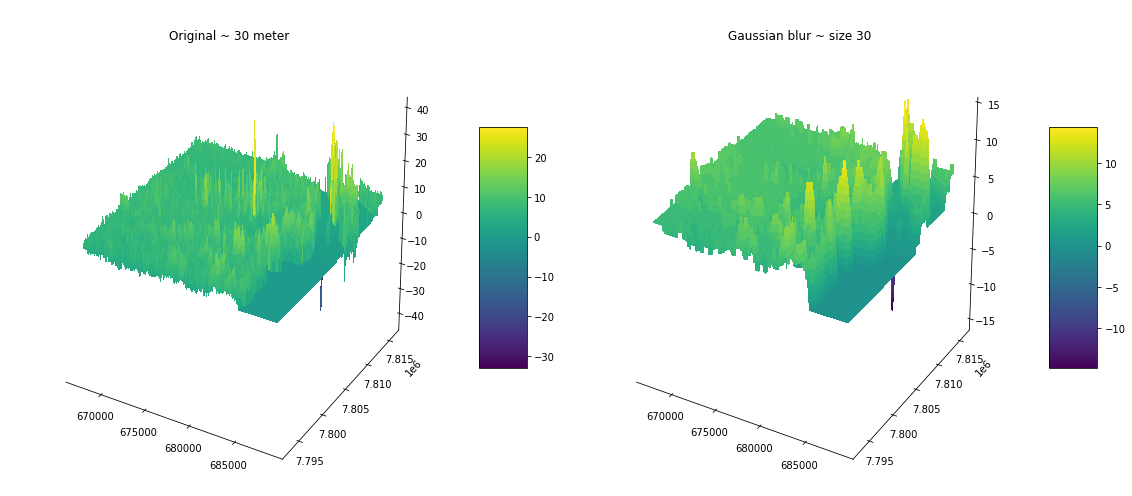

In [92]:
if variable == 5:
    view = da5
if variable == 10:
    view = da10
if variable == 20:
    view = da20
if variable == 30:
    view = da30
if variable == 40:
    view = da40

# set up a figure 
fig = plt.figure(figsize=(16, 7))

#transform the image
xres = elevation_array30.geobox.transform[0]
yres = elevation_array30.geobox.transform[4]
X = np.arange(dem30.geobox.transform[2], dem30.geobox.transform[2] + dem30.shape[1:][1]*xres, xres)
Y = np.arange(dem30.geobox.transform[5], dem30.geobox.transform[5] + dem30.shape[1:][0]*yres, yres)
X, Y = np.meshgrid(X, Y)

#do one image
ax1 = fig.add_subplot(121,projection='3d')

# make the panes transparent
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax1.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# plot a 3D surface --- oriented North West from the bottom right corner
surf1 = ax1.plot_surface(X, Y, dem30.squeeze(), rstride=2, cstride=2, cmap='viridis', linewidth=0, antialiased=False)
#w = ax.plot_surface(X,Y,w, rstride=2, cstride=2, color='b', linewidth=0, antialiased=True, zorder=1)
ax1.view_init(30, 300)
fig.colorbar(surf1, shrink=0.5, aspect=5)
ax1.set_title('Original ~ 30 meter')

#do another image
ax2 = fig.add_subplot(122,projection='3d')

# make the panes transparent
ax2.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax2.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax2.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax2.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# plot a 3D surface --- oriented North West from the bottom right corner
surf2 = ax2.plot_surface(X, Y, view.squeeze(), rstride=2, cstride=2, cmap='viridis', linewidth=0, antialiased=False)
#w = ax.plot_surface(X,Y,w, rstride=2, cstride=2, color='b', linewidth=0, antialiased=True, zorder=1)
ax2.view_init(30, 300)
fig.colorbar(surf2, shrink=0.5, aspect=5)
ax2.set_title('Gaussian blur ~ size '+str(variable))

plt.tight_layout() 
plt.show()

### Inundation Senario with DEM after Gaussian_blur size 30

In [78]:
flood_range = 7

In [79]:
mask = {}

for k in range(flood_range):
    mask[k] = da30 <= k

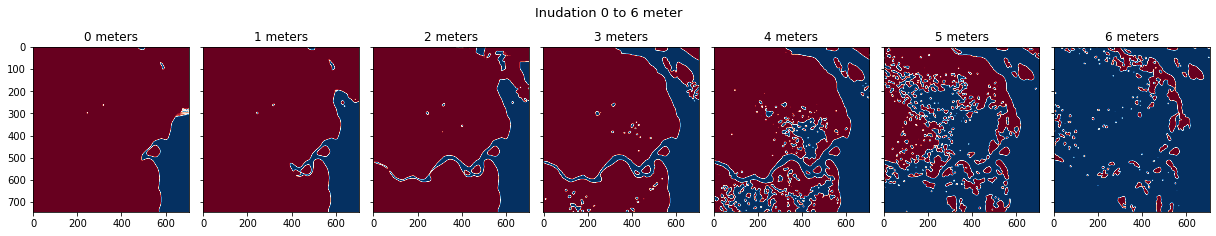

In [80]:
_, axs = plt.subplots(1, len(mask), figsize=(17, 17), sharey='row')
axs = axs.flatten()
for img, ax in zip(mask, axs):
    ax.imshow(mask[img].squeeze(), cmap='RdBu')
    ax.set_title(str(img) + ' meters')
    
plt.suptitle('Inudation 0 to 6 meter', size = 13, y = 0.6)
plt.tight_layout()
plt.show()

In [81]:
# Create a query
wofs_query = {
    'x': (lon_range),
    'y': (lat_range),
    'output_crs': 'EPSG:2736',    # utm36s
    'time': ('2018-01-01', '2018-12-30'),
    'resolution': (-30, 30)
}

# Load the data from the datacube
wofls = dc.load(product="ga_ls8c_wofs_2_annual_summary", group_by="solar_day",
                            fuse_func=wofs_fuser, **wofs_query)

In [82]:
mask_with90 = wofls.squeeze().frequency >= 0.9
mask_with90.values

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False]])

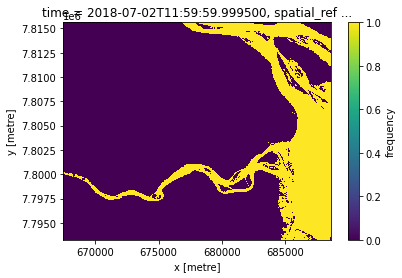

In [83]:
#plot
mask_with90.plot()

### New Inundation Senario with WOfS removed

In [84]:
new_mask = {}

for i in range(flood_range):
    new_mask[i] = mask[i].where(wofls.squeeze().frequency <= 0.9)

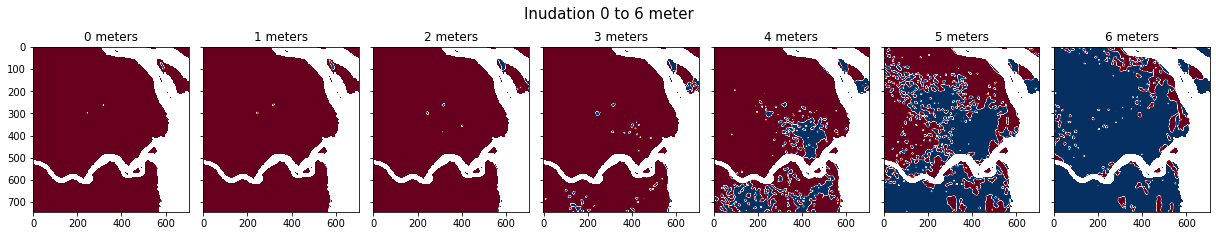

In [85]:
_, axs = plt.subplots(1, len(new_mask), figsize=(17, 17), sharey='row')
axs = axs.flatten()
for img, ax in zip(new_mask, axs):
    cb = ax.imshow(new_mask[img].squeeze(), cmap='RdBu')
    ax.set_title(str(img) + ' meters')

#plt.colorbar(cb)                                                      #perhaps a colorbar would be informative - add divider?
plt.suptitle('Inudation 0 to 6 meter', size = 15, y = 0.6)
plt.tight_layout()
plt.show()

### Compare with SAR ~ Sentinel 1: Beira_March 2019

In [86]:
#dataset = gdal.Open('../Supplementary_data/WorkingFolder/Beira_19032019_flooding.tif')#, gdal.GA_ReadOnly) 
dataset = gdal.Open('../Supplementary_data/WorkingFolder/beira_un-spider2.tif')
# Note GetRasterBand() takes band no. starting from 1 not 0
#band = dataset.GetRasterBand(1)
arr = dataset.ReadAsArray()

In [87]:
import matplotlib.gridspec as gridspec

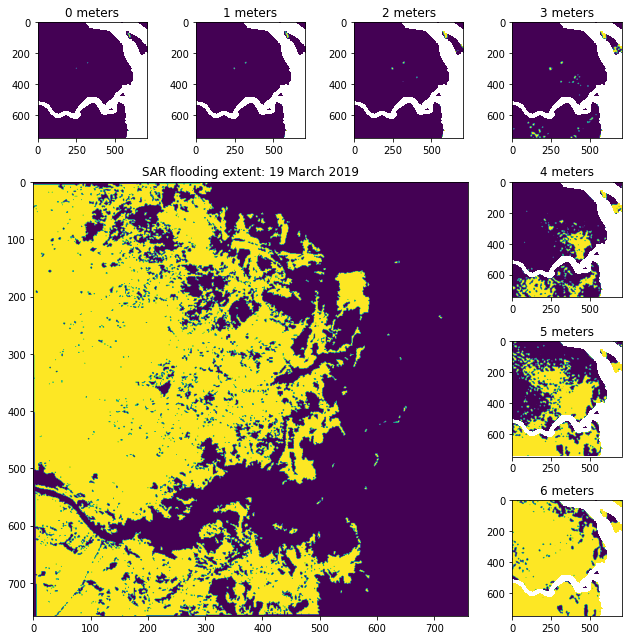

In [88]:
fig = plt.figure(figsize=(9, 9), constrained_layout=False)
a1 = plt.subplot2grid((4,4),(0,0))
a2 = plt.subplot2grid((4,4),(0,1))
a3 = plt.subplot2grid((4,4),(0,2))
a4 = plt.subplot2grid((4,4),(0,3))

a5 = plt.subplot2grid((4,4),(1,0), rowspan = 3, colspan = 3)

a6 = plt.subplot2grid((4,4),(1,3))
a7 = plt.subplot2grid((4,4),(2,3))
a8= plt.subplot2grid((4,4),(3,3))

a1.imshow(new_mask[0].squeeze())
a1.set_title('0 meters')
a2.imshow(new_mask[1].squeeze())
a2.set_title('1 meters')
a3.imshow(new_mask[2].squeeze())
a3.set_title('2 meters')
a4.imshow(new_mask[3].squeeze())
a4.set_title('3 meters')
a5.imshow(arr) #a1.set_title('exp')
#a5.imshow(mask_with90, zorder=2, alpha=0.3)
a5.set_title('SAR flooding extent: 19 March 2019')
a6.imshow(new_mask[4].squeeze())
a6.set_title('4 meters')
a7.imshow(new_mask[5].squeeze())
a7.set_title('5 meters')
a8.imshow(new_mask[6].squeeze())
a8.set_title('6 meters')

#plt.axes.xaxis.set_ticks([])
#plt.axes.yaxis.set_ticks([])
#plt.tick_labels('off')

plt.tight_layout()
plt.show()